# Goat Detection training

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets, models
from tqdm import tqdm
import cv2
from os import listdir


In [21]:
listdir("./data/goats/")

class GoatDataset(Dataset):
    def __init__(self, size=64):
        self.size = size
        self.transform = transforms.ToTensor()
        self.images = []

        goat_im_names = listdir("./data/goats/")
        self.num_goats = len(goat_im_names)
        for im_name in goat_im_names:
            # print(im_name)
            self.images.append(self.load_image("./data/goats/"+im_name))
        
        nongoat_im_names = listdir("./data/nongoats/")
        for im_name in nongoat_im_names:
            self.images.append(self.load_image("./data/nongoats/"+im_name))
        
        self.total_ims = len(self.images)

    def load_image(self, path):
        im = cv2.imread(path)
        im = cv2.resize(im, (self.size, self.size))
        im = self.transform(im)
        return im


    def __getitem__(self, index):
        is_goat = index<self.num_goats
        return self.images[index], torch.tensor(is_goat).float()

    def __len__(self):
        return self.total_ims

dataset = GoatDataset()
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

In [25]:
class GoatDetector(nn.Module):
    def __init__(self):
        super(GoatDetector, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.final_layer = nn.Linear(1000, 1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        return self.sig(self.final_layer(self.resnet(x)))


In [33]:
bne = nn.BCELoss()
model = GoatDetector()
model.cuda()
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-5)

In [34]:
accuracies = []
losses = []

In [35]:
epochs = 10
for epoch in range(epochs):

  loop = tqdm(total=len(dataloader), position=0)
  total = 0
  for i, (image, label) in enumerate(dataloader):
    image, label = image.cuda(), label.cuda()
    optimizer.zero_grad()

    out = model(image)

    loss = bne(out, label)
    loss.backward()
    optimizer.step()
    total += loss.item()
    preds = (out >= 0.5).float().squeeze(1)
    
    accuracy = (preds == label).sum().item() / len(label)
    accuracies.append(accuracy)
    losses.append(loss.item())

    loop.set_description('epoch:{:d} loss:{:.4f} accuracy:{:.2f}'.format(epoch, total/(i+1), accuracy))
    loop.update(1)
  loop.close()


epoch:9 loss:0.3673 accuracy:0.50: 100%|██████████| 73/73 [00:08<00:00,  8.20it/s]


Accuracy


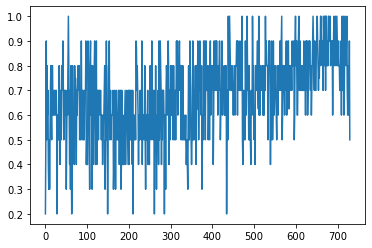

Loss


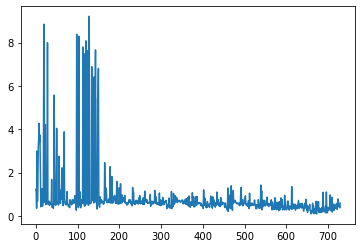

In [36]:
print("Accuracy")
plt.plot(accuracies)
plt.show()

print("Loss")
plt.plot(losses)
plt.show()

In [63]:
# def prepare_ims(names, shared_root=""):
#     tensors = []
#     for n in names:
#         path = shared_root+n
#         im = cv2.imread(path)
#         im = cv2.resize(im, (64, 64))
#         transform = transforms.ToTensor()
#         im = transform(im)
#         im = im.unsqueeze(0)
#         tensors.append(im)
# #     print(tensors)
#     return torch.cat(tensors, 0)

# images = prepare_ims(["cow.jfif", "goat.jfif", "car.jfif"], shared_root="./data/")


In [64]:
# print(images.size())
# images = images.cuda()
# out = model(images)
# preds = (out >= 0.5).float().squeeze(1)
# print(preds)

torch.Size([3, 3, 64, 64])
tensor([0., 0., 0.], device='cuda:0')
